In [21]:
################################################################################
#############  Purpose                     #####################################
## This code compares mean and variance estimates for Al+ time series 
## (not ratio) for high and low frequency of observations. The low frequency 
## is set to match the sampling rate of Sr. 
## The point is to see if the difference in sampling rates of the two clocks
## has any impact on the estimates of interest. 
################################################################################

import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
 

In [22]:

################################################################################
#############  Functions for data loading #####################################
################################################################################

## comb data 
def open_ErYb_data(data_path, header=2):
    # keys to read out as string
    key2read = ["MJD", "timer", "SDR:frep_ErYb", "fo_ErYb", "fb_Si_ErYb", "fb_Al_ErYb", "fb_Yb_ErYb"] 
    types = {key: str for key in key2read}
    types["MJD"] = float
 
    # # Read the CSV file
    data = pd.read_csv(data_path, header=1, delimiter="\t", dtype=types, engine="python")
 
    # Convert the strings to Decimal for the given keys
    for k in key2read:
        data[k] = data[k].apply(Decimal)
 
    # reindex data
    data.index = range(len(data))
 
    return data[list(types.keys())]

## Al shift data 
def open_shiftfile_Al(datapath):
    data = pd.read_csv(datapath, header=30, delimiter="\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
 ## Yb shift data
def open_shiftfile_Yb(datapath):
    data = pd.read_csv(datapath, header=8, delimiter=r"\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
 
 
################################################################################
#############  Functions to find optical frequencies with comb equation ########
################################################################################
 
# frequency for Al+ clock
def compute_nuAl_ErYb(data):
    data["nuAl"] = -Decimal("105e6") + Decimal("560444") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Al_ErYb"]
    data["nuAl"] = Decimal(4) * data["nuAl"]   

# freuency for Yb clock
def compute_nuYb_ErYb(data):
    data["nuYb"] = -Decimal("105e6") + Decimal("518237") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Yb_ErYb"]
    data["nuYb"] = Decimal(2) * data["nuYb"]

 
################################################################################
#############################  Load data #######################################
################################################################################
 
path = "/Users/smt3/Documents/GitHub/atomic-clock/st-interp/three_clocks/"

# load comb data
data_ErYb = open_ErYb_data(path + "20240813_Deglitched_ErYb_only1.dat")
 
# load Al shift data 
shift_data_Al = open_shiftfile_Al(path + "20240813_Al+_Freq_Shifts_ErYb.dat")

# load Yb shift data
shift_data_Yb = open_shiftfile_Yb(path + "20240813_Yb_Freq_Shifts.txt")
 

In [23]:
 
################################################################################
###############  get optical frequencies #############################
################################################################################
 
compute_nuAl_ErYb(data_ErYb)
compute_nuYb_ErYb(data_ErYb) 
 

################################################################################
#########################  Data Processing #####################################
################################################################################

## Extract only "IS_GOOD" data for analysis 
good_condition_al = shift_data_Al["IS_GOOD"] == 1
shift_data_Al_good = shift_data_Al[good_condition_al].reset_index(drop=True)
good_condition_yb = shift_data_Yb["IS_GOOD"] == 1
shift_data_Yb_good = shift_data_Yb[good_condition_yb].reset_index(drop=True)


# ## View frequency of MDJ observations  
# shift_data_Al["MJD_diff"] = shift_data_Al.MJD.diff()

# series_MJD_Al_diff = shift_data_Al["MJD_diff"]
# # plt.hist(series_MJD_Sr_diff.dropna(), bins = 500)
# # plt.xlim(0.00005, 0.00025)
# # plt.show()

# #print(series_MJD_Sr_diff.dtype)
# series_MJD_Al_diff.describe()

#mode MJD diff for Sr: 0.0001, max diff: 0.001224
#mode MJD diff for Al: 0.000012, max diff: 0.018264

common_mjd = data_ErYb["MJD"].astype(float)
nuAl = data_ErYb["nuAl"].astype(float)
nuYb = data_ErYb['nuYb'].astype(float)

print("Missing Al comb nu: ", nuAl.isna().sum())
print("Missing Yb comb nu: ", nuYb.isna().sum())

#is_na = nuAl.isna()
is_na = nuYb.isna()
max_streak = current_streak = 0
for val in is_na:
    if val:
        current_streak += 1
        max_streak = max(max_streak, current_streak)
    else:
        current_streak = 0
print("Total NaNs:", is_na.sum())
print("Longest sequence of NaNs:", max_streak, '\n')
#Note: nuYb ends before nuAl (though have matching MJD values)

len_comb = len(common_mjd) 
len_Al = len(shift_data_Al_good['shift'])             
len_yb = len(shift_data_Yb_good['shift'])

end_comb_inx = len_comb - 1 - max_streak
print("nuAl and nuYb start and end MJD: [", common_mjd[0], ', ', common_mjd[end_comb_inx], ']')
print("Al good shift start  and end MJD: [", shift_data_Al_good['MJD'][0], ', ', shift_data_Al_good['MJD'][len_Al-1], ']')
print("Yb good shift start and end MJD: [", shift_data_Yb_good['MJD'][0], ', ', shift_data_Yb_good['MJD'][len_yb-1], ']')

last_start_time = shift_data_Yb_good['MJD'][0]
first_end_time = shift_data_Yb_good['MJD'][len_yb-1]

# import missingno as msno
# df1 = nuAl.to_frame()
# msno.matrix(df1)
# plt.show()

# df2 = nuYb.to_frame()
# msno.matrix(df2)
# plt.show()

# df3 = shift_data_Yb_good 
# msno.matrix(df3)
# plt.show()

# df4 = shift_data_Al_good 
# msno.matrix(df4)
# plt.show()


Missing Al comb nu:  29
Missing Yb comb nu:  1500
Total NaNs: 1500
Longest sequence of NaNs: 1479 

nuAl and nuYb start and end MJD: [ 60535.682346 ,  60535.893888 ]
Al good shift start  and end MJD: [ 60535.6818403 ,  60535.9108218 ]
Yb good shift start and end MJD: [ 60535.68922818 ,  60535.89320398 ]


In [24]:
#function to extract element as close to target as possible w/out going over
def lb_extract(target, data):
    inx = 0
    stopper = 1
    while stopper == 1:
        if data[inx] <= target:
            inx += 1
        else:
            return inx  

#function to extract element as close to target as possible w/out going under 
def ub_extract(target, data):
    inx = 1
    stopper = 1
    while stopper == 1:
        if data[len(data)-inx] >= target:
            inx += 1
        else:
            return len(data)-inx  

#### first comb time point:  60535.682346  (# first good Al time point:  60535.6818403)
#### last good Al time point:  60535.9108218  (# last comb time point:  60535.911951)     

comb = pd.DataFrame()
comb_start = ub_extract(target = last_start_time, data = common_mjd)  
comb_end = lb_extract(target = first_end_time, data = common_mjd)  
comb["MJD"] = common_mjd[comb_start:comb_end] 
comb["nuAl"] = nuAl[comb_start:comb_end]
comb['nuAl'] = pd.to_numeric(comb['nuAl'], errors='coerce')
comb["nuYb"] = nuYb[comb_start:comb_end]
comb['nuYb'] = pd.to_numeric(comb['nuYb'], errors='coerce')

al_start = ub_extract(target = last_start_time, data = shift_data_Al_good["MJD"])
al_end = lb_extract(target = first_end_time, data = shift_data_Al_good["MJD"])  
shift_data_Al_high = shift_data_Al_good[al_start:al_end]

shift_data_Yb = shift_data_Yb_good

## reset df indicies for next step 
comb = comb.reset_index(drop=True)  
shift_data_Al_high = shift_data_Al_high.reset_index(drop=True)
shift_data_Yb = shift_data_Yb.reset_index(drop=True)

#shift_data_Al_high["MJD"].astype(float)
#shift_data_Al_high["shift"].astype(float)

#print(comb_high.head)
#print(shift_data_Al_high.head)



In [25]:

def sample_indices(df: pd.DataFrame, freq: int) -> pd.Index: #type annotation meaning the expected output is pandas object type Index 
    """
    Returns a sampled set of indices from the DataFrame at the specified frequency.

    Parameters:
    - df (pd.DataFrame): The DataFrame to sample from.
    - freq (int): The step size for sampling. For example, freq=2 will return every 2nd index.

    Returns:
    - pd.Index: A pandas Index containing the sampled indices.
    """
    if freq <= 0:
        raise ValueError("Frequency must be a positive integer.")
    
    return df.index[::freq]

inx_low = sample_indices(shift_data_Al_high["MJD"], 9)
shift_data_Al_low = shift_data_Al_high.loc[inx_low] 

print(len(shift_data_Al_low['MJD']))
print(len(shift_data_Al_high['MJD']))


1783
16047


In [26]:
################################################################################
#########################  Interpolation             ###########################
################################################################################
# Interpolate missing nuAl values in comb df 
#print(comb['nuAl'].isna().sum())
comb['nuAl'] = pd.to_numeric(comb['nuAl'], errors='coerce').interpolate(method='linear')
comb['nuAl'] = [Decimal(i) for i in comb['nuAl']]
comb['nuYb'] = pd.to_numeric(comb['nuYb'], errors='coerce').interpolate(method='linear')
comb['nuYb'] = [Decimal(i) for i in comb['nuYb']]

# Interpolate shift values to match comb grid 
shift_Al_low = np.interp(comb["MJD"], shift_data_Al_low["MJD"], shift_data_Al_low["shift"])
shift_Al_low = [Decimal(i) for i in shift_Al_low]
shift_Al_high = np.interp(comb["MJD"], shift_data_Al_high["MJD"], shift_data_Al_high["shift"])
shift_Al_high = [Decimal(i) for i in shift_Al_high]
shift_Yb = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_data_Yb["shift"])
shift_Yb = [Decimal(i) for i in shift_Yb]

#note: lengths should match now b/c both interpolated onto comb['MJD'] grid 
print(len(shift_Al_low))
print(len(shift_Al_high))

shift_data_Al_low = pd.DataFrame(shift_Al_low, columns=['shift_interpolated'])
shift_data_Al_high = pd.DataFrame(shift_Al_high, columns=['shift_interpolated'])
shift_data_Yb = pd.DataFrame(shift_Yb, columns=['shift_interpolated'])

16693
16693


Al/Yb ratio offset from BACON paper (low sampling for Al) -2.6214E-17


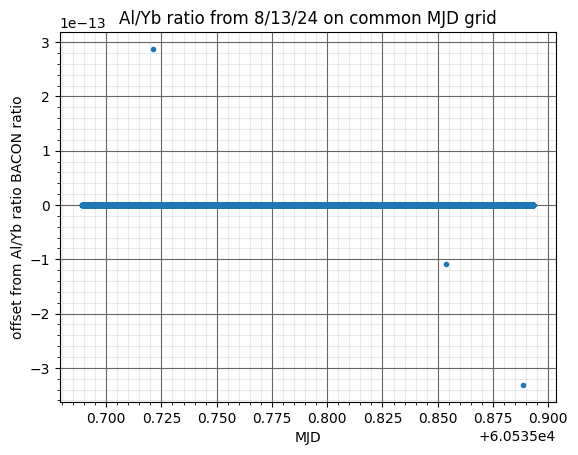

Al/Yb ratio offset from BACON paper (regular sampling for Al) -2.6108E-17


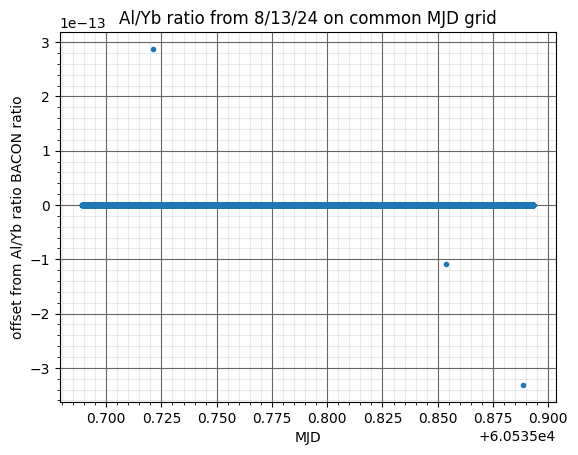

In [ ]:
AlYbRatio2020 = Decimal("2.162887127516663703")

# frequency corrections
masercorrection = Decimal("-7.36631e-12")
GR_shift_Al = Decimal("-8.114e-16")
GR_shift_Yb = Decimal("-8.109e-16")
GR_shift_sea_level = Decimal("-1798.501e-16")
total_correction_Al = Decimal("1") + GR_shift_Al + GR_shift_sea_level + masercorrection
total_correction_Yb = Decimal("1") + GR_shift_Yb + GR_shift_sea_level + masercorrection

frequency_Yb_ErYb = [(i + j) * total_correction_Yb for i,j in zip(comb["nuYb"], shift_data_Yb['shift_interpolated'])]
frequency_Al_ErYb_low = [(i + j) * total_correction_Al for i,j in zip(comb['nuAl'], shift_data_Al_low['shift_interpolated'])]
frequency_Al_ErYb_high = [(i + j) * total_correction_Al for i,j in zip(comb['nuAl'], shift_data_Al_high['shift_interpolated'])]
#print("Al+ ave with lower sampling rate", '{:0.5}'.format(np.nanmean(frequency_Al_ErYb_low)), '\n' )
#print("Al+ ave with higher sampling rate", '{:0.5}'.format(np.nanmean(frequency_Al_ErYb_high)), '\n' )


# Al/Yb ratio offset with low sampling rate for Al 
frequency_ratio_ErYb1 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb_low, frequency_Yb_ErYb)]
print("Al/Yb ratio offset from BACON paper (low sampling for Al)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1)) )
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Yb ratio BACON ratio")
plt.title("Al/Yb ratio from 8/13/24 on common MJD grid")
plt.show()

# Al/Yb ratio offset with high sampling rate for Al 
frequency_ratio_ErYb2 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb_high, frequency_Yb_ErYb)]
print("Al/Yb ratio offset from BACON paper (regular sampling for Al)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2)) )
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Yb ratio BACON ratio")
plt.title("Al/Yb ratio from 8/13/24 on common MJD grid")
plt.show()

## TODO 
# review original data analysis w/ attention to comb missing data 
# allentools package how to calculate allan variance OR see code in functions.R (overlapping_avar_fn)
#     aval plot (tau vs avar) and stability point estimate (extrapolated to whole data set, tau = length of time series) 

